In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station


/var/folders/yq/z9ljrl7178zcz_wv4vttyk7r0000gn/T/ipykernel_56079/3191658422.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set. should be ('2017-08-23')
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date in the data set is {most_recent_date[0]}")

The most recent date in the data set is 2017-08-23


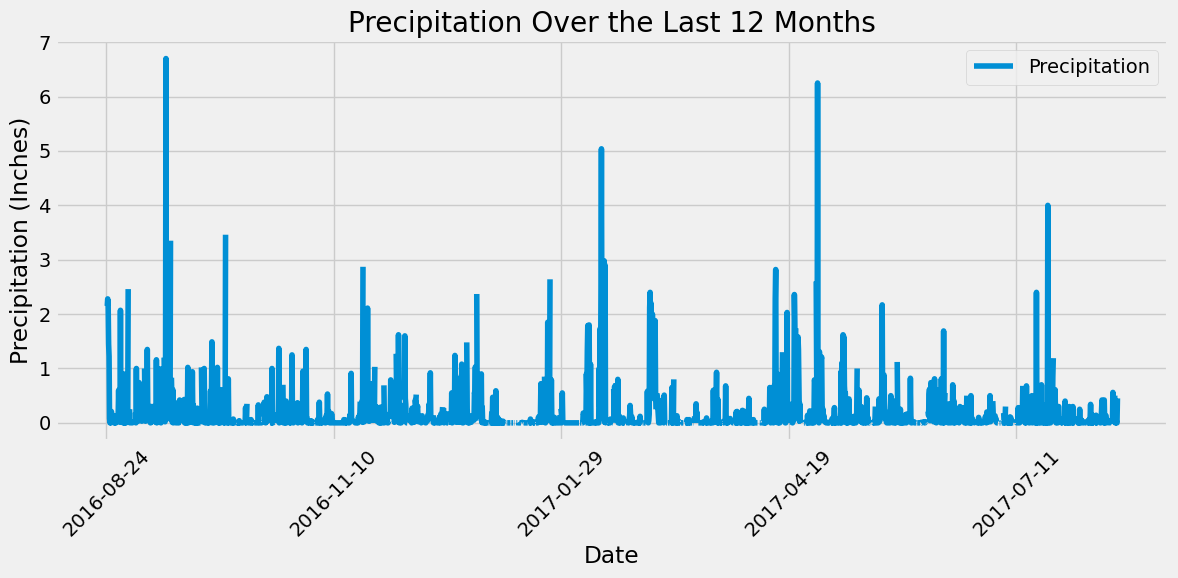

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

most_recent_date = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")
one_year_ago = most_recent_date - dt.timedelta(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    all()

df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df = df.sort_values(by='Date')

df.plot(x='Date', y='Precipitation', figsize=(12, 6))
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"There are a total of {total_stations} stations in the dataset.")

[(9,)]

In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

print("Most Active Stations (Station ID, Row Count):")
for station, count in most_active_stations:
    print(f"{station}, {count}")

Most Active Stations (Station ID, Row Count):
USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Should be [(54.0, 85.0, 71.66378066378067)] 
most_active_station_id = most_active_stations[0][0]
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()

print(most_active_station_id, lowest_temp, highest_temp, average_temp)

USC00519281 54.0 85.0 71.66378066378067


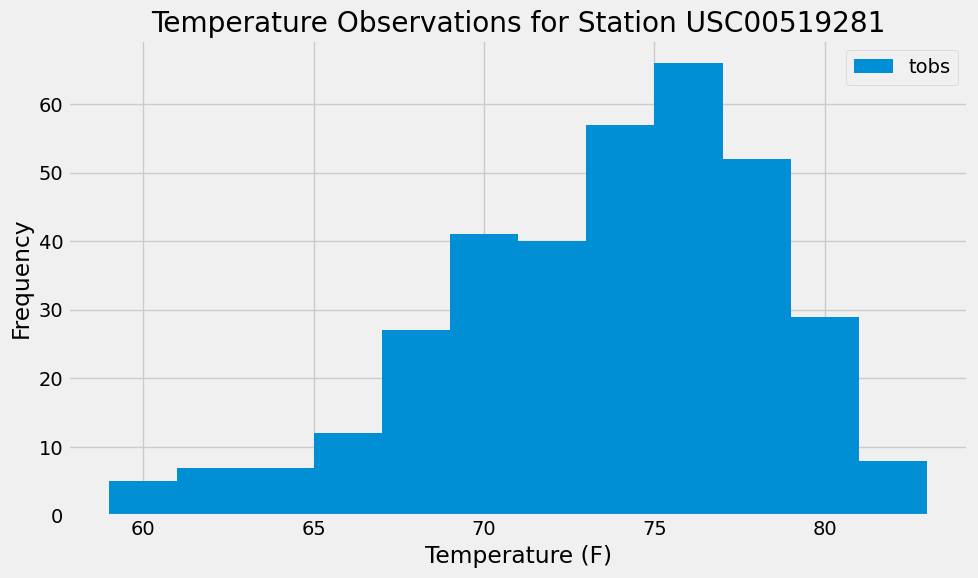

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    all()
temperatures = [temp[0] for temp in temperature_data]

plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.title(f'Temperature Observations for Station {most_active_station_id}')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()